In [1]:
import numpy as np
import pandas as pd
import os
import joblib
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

RANDOM_STATE = 55 ## We will pass it to every sklearn call so we ensure reproducibility

# Load the Data and set up train and test

In [2]:
data_path = os.path.dirname(os.getcwd()) + '/data'
data_prefix = '/broad_assets_'
train_file = data_path + data_prefix + 'classifier_train_data.xlsx'
test_file = data_path + data_prefix + 'classifier_test_data.xlsx'

train = pd.read_excel(train_file, index_col=0)
test = pd.read_excel(test_file, index_col=0)

display(train.head(3))
display(test.head(3))

,roc_4w,roc_6w,roc_12w,roc_26w,roc_52w,rsi,rolling_vol_20,rolling_vol_60,rolling_vol_126,rolling_vol_252,...,bb_180d_upper_lag12,bb_180d_lower_lag12,bb_240d_sma_lag12,bb_240d_upper_lag12,bb_240d_lower_lag12,ht_dcperiod_lag12,ht_dcphase_lag12,inphase_lag12,sine_lag12,ht_trendmode_lag12
0,0.179938,-0.015962,0.113473,-0.331601,-0.353315,69.834011,0.047987,0.042589,0.040460,0.032232,...,0.054315,-0.060777,-0.002630,0.055478,-0.060737,27.931670,21.556555,0.053882,0.367419,1
1,0.328094,0.172510,-0.009726,-0.286688,-0.355783,58.959543,0.040207,0.040163,0.040498,0.032037,...,0.057121,-0.061700,-0.001864,0.057424,-0.061152,23.817833,79.494072,-0.046896,0.983236,1
2,0.078867,0.142590,-0.166120,-0.362345,-0.417442,45.771405,0.035658,0.039211,0.039808,0.032197,...,0.059317,-0.062803,-0.001309,0.059165,-0.061783,20.340871,187.203927,0.028316,-0.125401,1


,roc_4w,roc_6w,roc_12w,roc_26w,roc_52w,rsi,rolling_vol_20,rolling_vol_60,rolling_vol_126,rolling_vol_252,...,bb_180d_upper_lag12,bb_180d_lower_lag12,bb_240d_sma_lag12,bb_240d_upper_lag12,bb_240d_lower_lag12,ht_dcperiod_lag12,ht_dcphase_lag12,inphase_lag12,sine_lag12,ht_trendmode_lag12
0,0.187026,0.407435,-0.281530,-0.176327,-0.122810,66.423096,0.054331,0.078819,0.054682,0.040576,...,0.032255,-0.029296,0.001406,0.031306,-0.028493,28.262975,214.841402,-0.192672,-0.571307,0
1,0.132009,0.572994,-0.342825,-0.217884,-0.139319,50.350531,0.049108,0.079160,0.055134,0.040863,...,0.032898,-0.028813,0.001647,0.031931,-0.028636,24.434966,302.453574,-0.074435,-0.843827,1
2,0.120638,0.229251,-0.313374,-0.174002,-0.004822,70.770729,0.036574,0.079376,0.055262,0.040906,...,0.032952,-0.028411,0.001727,0.031970,-0.028516,20.309540,124.549631,0.161411,0.823635,1


In [3]:
features = [col for col in train.columns if col not in 'target']
X_train, y_train, X_val, y_val = train.loc[:, features], train['target'], test.loc[:, features], test['target']
n = int(len(X_train)*0.8) ## Let's use 80% to train and 20% to eval
X_train_fit, X_train_eval, y_train_fit, y_train_eval = X_train[:n], X_train[n:], y_train[:n], y_train[n:]

## Decision Tree

In [4]:
min_samples_split_list = [2,10, 30, 50, 100, 200, 300, 700, 1000] ## If the number is an integer, then it is the actual quantity of samples,
max_depth_list = [1,2, 3, 4, 8, 16, 32, 64, None] # None means that there is no depth limit.

### Min Samples Hyperparameter Analysis

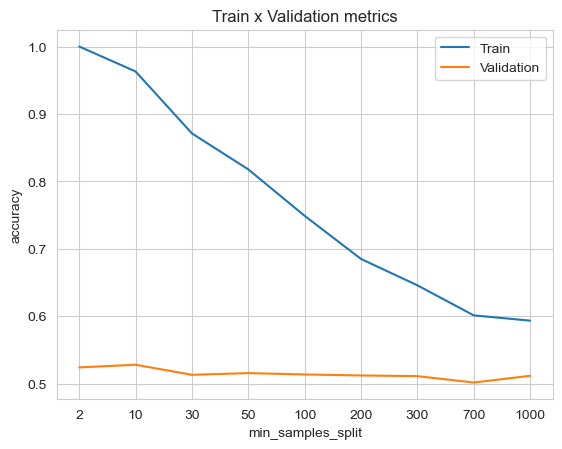

In [5]:
accuracy_list_train = []
accuracy_list_val = []
for min_samples_split in min_samples_split_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = DecisionTreeClassifier(min_samples_split = min_samples_split,
                                   random_state = RANDOM_STATE).fit(X_train_fit,y_train_fit) 
    predictions_train = model.predict(X_train_fit) ## The predicted values for the train dataset
    predictions_val = model.predict(X_train_eval) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train_fit)
    accuracy_val = accuracy_score(predictions_val,y_train_eval)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('min_samples_split')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(min_samples_split_list )),labels=min_samples_split_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

### Max Depth Hyperparameter Analysis

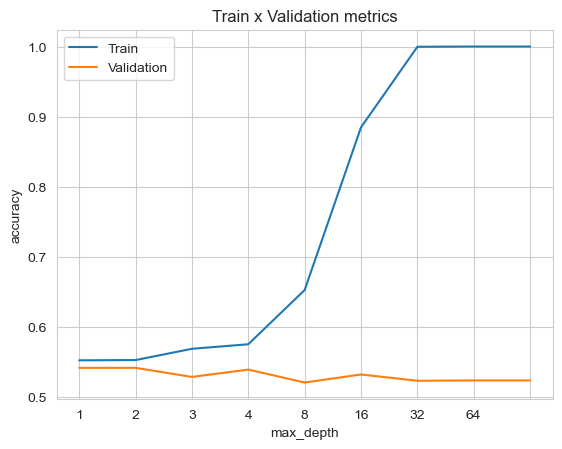

In [6]:
accuracy_list_train = []
accuracy_list_val = []
for max_depth in max_depth_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = DecisionTreeClassifier(max_depth= max_depth,
                                   random_state = RANDOM_STATE).fit(X_train_fit,y_train_fit) 
    predictions_train = model.predict(X_train_fit) ## The predicted values for the train dataset
    predictions_val = model.predict(X_train_eval) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train_fit)
    accuracy_val = accuracy_score(predictions_val,y_train_eval)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(max_depth_list )),labels=max_depth_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

In [7]:
decision_tree_model = DecisionTreeClassifier(min_samples_split = 750,
                                             max_depth = 1,
                                             random_state = RANDOM_STATE).fit(X_train,y_train)

print(f"Metrics train:\n\tAccuracy score: {accuracy_score(decision_tree_model.predict(X_train),y_train):.4f}")
print(f"Metrics validation:\n\tAccuracy score: {accuracy_score(decision_tree_model.predict(X_val),y_val):.4f}")

Metrics train:
	Accuracy score: 0.5506
Metrics validation:
	Accuracy score: 0.5299


In [8]:
dt_features = list(zip(features, decision_tree_model.feature_importances_))
sorted(dt_features, key=lambda x: x[1], reverse=True)

[('MACD_Histogram', 1.0),
 ('roc_4w', 0.0),
 ('roc_6w', 0.0),
 ('roc_12w', 0.0),
 ('roc_26w', 0.0),
 ('roc_52w', 0.0),
 ('rsi', 0.0),
 ('rolling_vol_20', 0.0),
 ('rolling_vol_60', 0.0),
 ('rolling_vol_126', 0.0),
 ('rolling_vol_252', 0.0),
 ('rolling_vol_504', 0.0),
 ('rolling_skew_20', 0.0),
 ('rolling_skew_60', 0.0),
 ('rolling_skew_126', 0.0),
 ('rolling_skew_252', 0.0),
 ('rolling_skew_504', 0.0),
 ('rolling_kurt_20', 0.0),
 ('rolling_kurt_60', 0.0),
 ('rolling_kurt_126', 0.0),
 ('rolling_kurt_252', 0.0),
 ('rolling_kurt_504', 0.0),
 ('ewma_vol', 0.0),
 ('skew', 0.0),
 ('kurtosis', 0.0),
 ('MACD_Line', 0.0),
 ('Signal_Line', 0.0),
 ('stoch_rsi', 0.0),
 ('bb_20d_sma', 0.0),
 ('bb_20d_upper', 0.0),
 ('bb_20d_lower', 0.0),
 ('bb_90d_sma', 0.0),
 ('bb_90d_upper', 0.0),
 ('bb_90d_lower', 0.0),
 ('bb_180d_sma', 0.0),
 ('bb_180d_upper', 0.0),
 ('bb_180d_lower', 0.0),
 ('bb_240d_sma', 0.0),
 ('bb_240d_upper', 0.0),
 ('bb_240d_lower', 0.0),
 ('ht_dcperiod', 0.0),
 ('ht_dcphase', 0.0),
 ('in

## Random Forest

In [9]:
min_samples_split_list = [2,10, 30, 50, 100, 200, 300, 700, 1000]  ## If the number is an integer, then it is the actual quantity of samples,
                                             ## If it is a float, then it is the percentage of the dataset
max_depth_list = [2, 4, 8, 16, 32, 64, None]
n_estimators_list = [10,50,100,500]

### Min Samples Hyperparameter Analysis

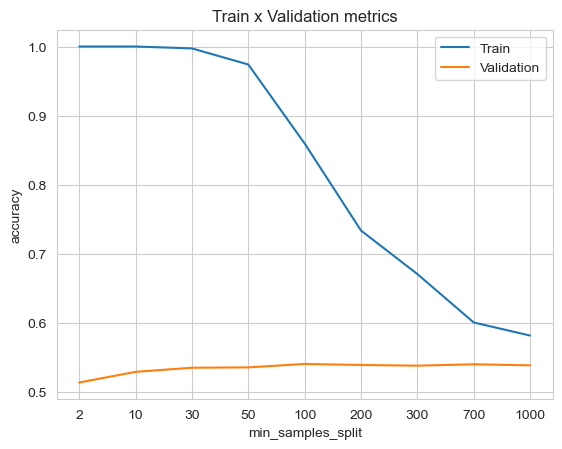

In [10]:
accuracy_list_train = []
accuracy_list_val = []
for min_samples_split in min_samples_split_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(min_samples_split = min_samples_split,
                                   random_state = RANDOM_STATE).fit(X_train_fit,y_train_fit) 
    predictions_train = model.predict(X_train_fit) ## The predicted values for the train dataset
    predictions_val = model.predict(X_train_eval) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train_fit)
    accuracy_val = accuracy_score(predictions_val,y_train_eval)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('min_samples_split')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(min_samples_split_list )),labels=min_samples_split_list) 
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

### Max Depth Hyperparameter Analysis

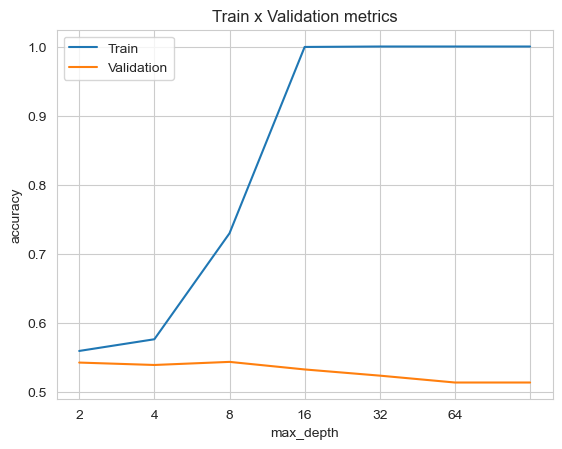

In [11]:
accuracy_list_train = []
accuracy_list_val = []
for max_depth in max_depth_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(max_depth=max_depth,
                                   random_state = RANDOM_STATE).fit(X_train_fit,y_train_fit) 
    predictions_train = model.predict(X_train_fit) ## The predicted values for the train dataset
    predictions_val = model.predict(X_train_eval) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train_fit)
    accuracy_val = accuracy_score(predictions_val,y_train_eval)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(max_depth_list )),labels=max_depth_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

### N Estimators Hyperparameter Analysis

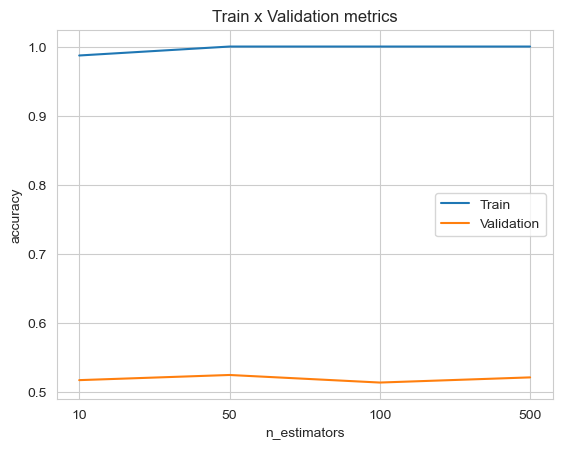

In [12]:
accuracy_list_train = []
accuracy_list_val = []
for n_estimators in n_estimators_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(n_estimators=n_estimators,
                                   random_state = RANDOM_STATE).fit(X_train_fit,y_train_fit) 
    predictions_train = model.predict(X_train_fit) ## The predicted values for the train dataset
    predictions_val = model.predict(X_train_eval) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train_fit)
    accuracy_val = accuracy_score(predictions_val,y_train_eval)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(n_estimators_list )),labels=n_estimators_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

In [25]:
random_forest_model = RandomForestClassifier(n_estimators=500,
                                             min_samples_split=750,
                                             max_depth=2).fit(X_train,y_train)
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(y_train, random_forest_model.predict(X_train)):.4f}\
      \n\tF1 score: {f1_score(y_train, random_forest_model.predict(X_train)):.4f}\
      \nMetrics test:\n\tAccuracy score: {accuracy_score(y_val, random_forest_model.predict(X_val)):.4f}\
      \n\tF1 Score: {f1_score(y_val, random_forest_model.predict(X_val)):.4f}")

Metrics train:
	Accuracy score: 0.5539      
	F1 score: 0.7067      
Metrics test:
	Accuracy score: 0.5315      
	F1 Score: 0.6914


### Hyperparameter Search

In [14]:
# Define the hyperparameter grid
param_grid = {
    'max_depth': max_depth_list,
    'min_samples_split': min_samples_split_list,
    'n_estimators': n_estimators_list
}

# Create the XGBoost model object
random_forest_model = RandomForestClassifier(random_state=RANDOM_STATE, verbose=1)

# TODO: Tune on both Accuracy and F1 scores and compare portfolio performance of each
# Create the GridSearchCV object
acc_grid_search = RandomizedSearchCV(random_forest_model, param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the training data
acc_grid_search.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", acc_grid_search.best_params_)
print("Best score: ", acc_grid_search.best_score_)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   14.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:   31.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   13.7s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:   30.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   13.7s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:   30.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Best set of hyperparameters:  {'n_estimators': 10, 'min_samples_split': 300, 'max_depth': 2}
Best score:  0.532314048931204


In [15]:
# Define the hyperparameter grid
param_grid = {
    'max_depth': max_depth_list,
    'min_samples_split': min_samples_split_list,
    'n_estimators': n_estimators_list
}

# Create the XGBoost model object
random_forest_model = RandomForestClassifier(random_state=RANDOM_STATE, verbose=1)

# TODO: Tune on both Accuracy and F1 scores and compare portfolio performance of each
# Create the GridSearchCV object
f1_grid_search = RandomizedSearchCV(random_forest_model, param_grid, cv=5, scoring='f1')

# Fit the GridSearchCV object to the training data
f1_grid_search.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", f1_grid_search.best_params_)
print("Best score: ", f1_grid_search.best_score_)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    7.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    6.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    7.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    6.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    7.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Best set of hyperparameters:  {'n_estimators': 50, 'min_samples_split': 300, 'max_depth': 2}
Best score:  0.6682555037532981


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.3s


In [21]:
# Model tuned for Accuracy
random_forest_acc_model = RandomForestClassifier(**acc_grid_search.best_params_).fit(X_train,y_train)
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(y_train, random_forest_acc_model.predict(X_train)):.4f}\
      \n\tF1 score: {f1_score(y_train, random_forest_acc_model.predict(X_train)):.4f}\
      \nMetrics test:\n\tAccuracy score: {accuracy_score(y_val, random_forest_acc_model.predict(X_val)):.4f}\
      \n\tF1 score: {f1_score(y_val, random_forest_acc_model.predict(X_val)):.4f}")

Metrics train:
	Accuracy score: 0.5556      
	F1 score: 0.7066      
Metrics test:
	Accuracy score: 0.5315      
	F1 score: 0.6899


In [22]:
# Model tuned for F1-Score
random_forest_f1_model = RandomForestClassifier(**f1_grid_search.best_params_).fit(X_train,y_train)
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(y_train, random_forest_f1_model.predict(X_train)):.4f}\
      \n\tF1 score: {f1_score(y_train, random_forest_f1_model.predict(X_train)):.4f}\
      \nMetrics test:\n\tAccuracy score: {accuracy_score(y_val, random_forest_f1_model.predict(X_val)):.4f}\
      \n\tF1 score: {f1_score(y_val, random_forest_f1_model.predict(X_val)):.4f}")

Metrics train:
	Accuracy score: 0.5544      
	F1 score: 0.7070      
Metrics test:
	Accuracy score: 0.5275      
	F1 score: 0.6886


In [ ]:
rf_features = list(zip(features, random_forest_model.feature_importances_))
sorted(rf_features, key=lambda x: x[1], reverse=True)

[('stoch_rsi_lag4', 0.038584917943136815),
 ('MACD_Line', 0.03618015282056448),
 ('MACD_Histogram', 0.035649451761301486),
 ('bb_180d_sma_lag2', 0.021069495248847832),
 ('bb_180d_sma_lag1', 0.02059718787309186),
 ('MACD_Histogram_lag12', 0.01827156033565349),
 ('bb_90d_sma_lag1', 0.018063249269663177),
 ('inphase_lag6', 0.016527215834621765),
 ('bb_20d_upper', 0.015949451911249198),
 ('MACD_Histogram_lag6', 0.015239959495486257),
 ('bb_180d_sma_lag12', 0.013716824478860972),
 ('Signal_Line_lag1', 0.013708753145279116),
 ('bb_90d_sma_lag4', 0.01347949253901264),
 ('MACD_Line_lag4', 0.013070892550457628),
 ('bb_180d_sma', 0.011842539486564762),
 ('MACD_Line_lag2', 0.011769592234716367),
 ('MACD_Line_lag1', 0.011622412239411413),
 ('bb_240d_sma_lag1', 0.011394210282463693),
 ('bb_90d_upper', 0.01131746356852226),
 ('roc_26w_lag1', 0.011085936906654442),
 ('bb_240d_sma_lag2', 0.010447253359806785),
 ('ewma_vol', 0.009762252579908572),
 ('roc_4w_lag6', 0.009683791406837484),
 ('rsi_lag4', 0

In [23]:
rf_features = list(zip(features, random_forest_acc_model.feature_importances_))
sorted(rf_features, key=lambda x: x[1], reverse=True)

[('bb_90d_sma_lag4', 0.16465678529234878),
 ('MACD_Line', 0.08454423396925945),
 ('bb_20d_lower', 0.058188788397703986),
 ('bb_180d_sma_lag2', 0.0572205594239598),
 ('stoch_rsi_lag2', 0.052850436066556816),
 ('rolling_kurt_126', 0.050155802392503945),
 ('kurtosis_lag1', 0.04984419760749605),
 ('rolling_vol_60_lag4', 0.047149563933443175),
 ('roc_26w', 0.04669408386128947),
 ('MACD_Histogram', 0.04576370613787793),
 ('rolling_kurt_252_lag6', 0.04288542470848382),
 ('roc_26w_lag1', 0.04181121160229602),
 ('bb_240d_upper', 0.04005468010986114),
 ('rolling_vol_20', 0.03896265638735689),
 ('bb_20d_upper', 0.036262465721034365),
 ('rsi_lag12', 0.03530251065996598),
 ('ht_dcperiod_lag2', 0.03275200046001138),
 ('bb_20d_sma_lag1', 0.028285343152631738),
 ('bb_20d_upper_lag1', 0.024642809230172865),
 ('rolling_vol_252_lag4', 0.021972740885746387),
 ('roc_4w', 0.0),
 ('roc_6w', 0.0),
 ('roc_12w', 0.0),
 ('roc_52w', 0.0),
 ('rsi', 0.0),
 ('rolling_vol_60', 0.0),
 ('rolling_vol_126', 0.0),
 ('roll

In [24]:
rf_features = list(zip(features, random_forest_f1_model.feature_importances_))
sorted(rf_features, key=lambda x: x[1], reverse=True)

[('stoch_rsi_lag4', 0.035124140992163974),
 ('MACD_Histogram', 0.03313491395188294),
 ('MACD_Histogram_lag6', 0.032999834506782094),
 ('MACD_Line_lag1', 0.03157761940863523),
 ('roc_26w_lag2', 0.027366194578477884),
 ('ewma_vol_lag2', 0.027357526160106237),
 ('MACD_Line', 0.026685038695655337),
 ('bb_90d_sma_lag6', 0.025526823806389282),
 ('rolling_vol_20_lag12', 0.024371265029230597),
 ('roc_4w_lag6', 0.023656265099891795),
 ('bb_90d_upper', 0.0229672952988224),
 ('bb_180d_sma_lag2', 0.020754552281146692),
 ('inphase_lag6', 0.020375355054639215),
 ('bb_20d_sma_lag12', 0.018815780236724068),
 ('rsi_lag4', 0.01796041823499624),
 ('MACD_Histogram_lag4', 0.01767051573346191),
 ('rolling_kurt_126_lag12', 0.017588481198079594),
 ('MACD_Line_lag12', 0.017584462974377643),
 ('Signal_Line_lag1', 0.01708416633072136),
 ('roc_52w_lag2', 0.01610648897740522),
 ('inphase_lag4', 0.015897674007618462),
 ('bb_180d_lower_lag2', 0.01513871249976315),
 ('bb_240d_sma_lag2', 0.014325900313206052),
 ('roc_

## XGBoost

In [26]:
# Define the hyperparameter grid
param_grid = {
    'max_depth': [8, 32, None],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [50, 100, 500]
}

# Create the XGBoost model object
xgb_model = XGBClassifier(early_stopping_rounds=30, verbosity=1, random_state=RANDOM_STATE)

# TODO: Tune on both Accuracy and F1 scores and compare portfolio performance of each
# Create the GridSearchCV object
acc_grid_search = RandomizedSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the training data
acc_grid_search.fit(X_train_fit, y_train_fit, eval_set = [(X_train_eval,y_train_eval)])

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", acc_grid_search.best_params_)
print("Best score: ", acc_grid_search.best_score_)

[0]	validation_0-logloss:0.68987
[1]	validation_0-logloss:0.68987
[2]	validation_0-logloss:0.68987
[3]	validation_0-logloss:0.68987
[4]	validation_0-logloss:0.68987
[5]	validation_0-logloss:0.68987
[6]	validation_0-logloss:0.68987
[7]	validation_0-logloss:0.68987
[8]	validation_0-logloss:0.68987
[9]	validation_0-logloss:0.68987
[10]	validation_0-logloss:0.68987
[11]	validation_0-logloss:0.68987
[12]	validation_0-logloss:0.68987
[13]	validation_0-logloss:0.68987
[14]	validation_0-logloss:0.68986
[15]	validation_0-logloss:0.68986
[16]	validation_0-logloss:0.68985
[17]	validation_0-logloss:0.68985
[18]	validation_0-logloss:0.68984
[19]	validation_0-logloss:0.68984
[20]	validation_0-logloss:0.68983
[21]	validation_0-logloss:0.68983
[22]	validation_0-logloss:0.68982
[23]	validation_0-logloss:0.68981
[24]	validation_0-logloss:0.68981
[25]	validation_0-logloss:0.68981
[26]	validation_0-logloss:0.68981
[27]	validation_0-logloss:0.68980
[28]	validation_0-logloss:0.68980
[29]	validation_0-loglos

In [27]:
# Define the hyperparameter grid
param_grid = {
    'max_depth': [8, 32, None],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [50, 100, 500]
}

# Create the XGBoost model object
xgb_model = XGBClassifier(early_stopping_rounds=30, verbosity=1, random_state=RANDOM_STATE)

# TODO: Tune on both Accuracy and F1 scores and compare portfolio performance of each
# Create the GridSearchCV object
f1_grid_search = RandomizedSearchCV(xgb_model, param_grid, cv=5, scoring='f1')

# Fit the GridSearchCV object to the training data
f1_grid_search.fit(X_train_fit, y_train_fit, eval_set = [(X_train_eval,y_train_eval)])

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", f1_grid_search.best_params_)
print("Best score: ", f1_grid_search.best_score_)

[0]	validation_0-logloss:0.68993
[1]	validation_0-logloss:0.69000
[2]	validation_0-logloss:0.68986
[3]	validation_0-logloss:0.68984
[4]	validation_0-logloss:0.68984
[5]	validation_0-logloss:0.69000
[6]	validation_0-logloss:0.68994
[7]	validation_0-logloss:0.68999
[8]	validation_0-logloss:0.69015
[9]	validation_0-logloss:0.69020
[10]	validation_0-logloss:0.69024
[11]	validation_0-logloss:0.69049
[12]	validation_0-logloss:0.69066
[13]	validation_0-logloss:0.69098
[14]	validation_0-logloss:0.69088
[15]	validation_0-logloss:0.69090
[16]	validation_0-logloss:0.69093
[17]	validation_0-logloss:0.69115
[18]	validation_0-logloss:0.69119
[19]	validation_0-logloss:0.69127
[20]	validation_0-logloss:0.69128
[21]	validation_0-logloss:0.69131
[22]	validation_0-logloss:0.69135
[23]	validation_0-logloss:0.69123
[24]	validation_0-logloss:0.69125
[25]	validation_0-logloss:0.69121
[26]	validation_0-logloss:0.69129
[27]	validation_0-logloss:0.69135
[28]	validation_0-logloss:0.69154
[29]	validation_0-loglos

In [28]:
# Fitting model optimized for accuracy
xgb_acc_model = XGBClassifier(verbosity = 1, random_state = RANDOM_STATE, early_stopping_rounds=30, **acc_grid_search.best_params_)
xgb_acc_model.fit(X_train_fit,y_train_fit, eval_set = [(X_train_eval,y_train_eval)])

[0]	validation_0-logloss:0.68986
[1]	validation_0-logloss:0.68986
[2]	validation_0-logloss:0.68985
[3]	validation_0-logloss:0.68984
[4]	validation_0-logloss:0.68984
[5]	validation_0-logloss:0.68983
[6]	validation_0-logloss:0.68982
[7]	validation_0-logloss:0.68981
[8]	validation_0-logloss:0.68981
[9]	validation_0-logloss:0.68980
[10]	validation_0-logloss:0.68980
[11]	validation_0-logloss:0.68979
[12]	validation_0-logloss:0.68979
[13]	validation_0-logloss:0.68978
[14]	validation_0-logloss:0.68978
[15]	validation_0-logloss:0.68977
[16]	validation_0-logloss:0.68977
[17]	validation_0-logloss:0.68976
[18]	validation_0-logloss:0.68976
[19]	validation_0-logloss:0.68975
[20]	validation_0-logloss:0.68975
[21]	validation_0-logloss:0.68974
[22]	validation_0-logloss:0.68974
[23]	validation_0-logloss:0.68973
[24]	validation_0-logloss:0.68973
[25]	validation_0-logloss:0.68972
[26]	validation_0-logloss:0.68972
[27]	validation_0-logloss:0.68972
[28]	validation_0-logloss:0.68972
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=30,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=55, ...)

In [29]:
# Fitting model optimized for F1-score
xgb_f1_model = XGBClassifier(verbosity = 1, random_state = RANDOM_STATE, early_stopping_rounds=30, **f1_grid_search.best_params_)
xgb_f1_model.fit(X_train_fit,y_train_fit, eval_set = [(X_train_eval,y_train_eval)])

[0]	validation_0-logloss:0.68986
[1]	validation_0-logloss:0.68986
[2]	validation_0-logloss:0.68985
[3]	validation_0-logloss:0.68984
[4]	validation_0-logloss:0.68984
[5]	validation_0-logloss:0.68983
[6]	validation_0-logloss:0.68982
[7]	validation_0-logloss:0.68981
[8]	validation_0-logloss:0.68981
[9]	validation_0-logloss:0.68980
[10]	validation_0-logloss:0.68980
[11]	validation_0-logloss:0.68979
[12]	validation_0-logloss:0.68979
[13]	validation_0-logloss:0.68978
[14]	validation_0-logloss:0.68978
[15]	validation_0-logloss:0.68977
[16]	validation_0-logloss:0.68977
[17]	validation_0-logloss:0.68976
[18]	validation_0-logloss:0.68976
[19]	validation_0-logloss:0.68975
[20]	validation_0-logloss:0.68975
[21]	validation_0-logloss:0.68974
[22]	validation_0-logloss:0.68974
[23]	validation_0-logloss:0.68973
[24]	validation_0-logloss:0.68973
[25]	validation_0-logloss:0.68972
[26]	validation_0-logloss:0.68972
[27]	validation_0-logloss:0.68972
[28]	validation_0-logloss:0.68972
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=30,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=55, ...)

In [36]:
# Model tune for accuracy
xgb_acc_model.best_iteration
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(xgb_acc_model.predict(X_train),y_train):.4f}\
      \n\tF1 score: {f1_score(xgb_acc_model.predict(X_train),y_train):.4f}\
      \nMetrics test:\n\tAccuracy score: {accuracy_score(xgb_acc_model.predict(X_val),y_val):.4f}\
      \n\tF1 score: {f1_score(xgb_acc_model.predict(X_val),y_val):.4f}")

Metrics train:
	Accuracy score: 0.5469      
	F1 score: 0.7071      
Metrics test:
	Accuracy score: 0.5291      
	F1 score: 0.6920


In [37]:
# Model tuned for f1
xgb_f1_model.best_iteration
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(xgb_f1_model.predict(X_train),y_train):.4f}\
      \n\tF1 score: {f1_score(xgb_f1_model.predict(X_train),y_train):.4f}\
      \nMetrics test:\n\tAccuracy score: {accuracy_score(xgb_f1_model.predict(X_val),y_val):.4f}\
      \n\tF1 score: {f1_score(xgb_f1_model.predict(X_val),y_val):.4f}")

Metrics train:
	Accuracy score: 0.5469      
	F1 score: 0.7071      
Metrics test:
	Accuracy score: 0.5291      
	F1 score: 0.6920


In [34]:
xgb_features = list(zip(features, xgb_acc_model.feature_importances_))
sorted(xgb_features, key=lambda x: x[1], reverse=True)

[('stoch_rsi_lag4', 0.022773003),
 ('roc_4w', 0.020792192),
 ('bb_20d_sma_lag6', 0.020728128),
 ('MACD_Line', 0.020630011),
 ('bb_180d_sma_lag1', 0.0206233),
 ('bb_180d_sma', 0.0183816),
 ('rolling_skew_126_lag6', 0.018359188),
 ('rolling_skew_126_lag2', 0.018220268),
 ('MACD_Histogram', 0.017091345),
 ('MACD_Line_lag2', 0.016697582),
 ('rolling_vol_504_lag12', 0.016276399),
 ('MACD_Histogram_lag12', 0.01516808),
 ('rolling_kurt_60', 0.014524336),
 ('rolling_kurt_504_lag2', 0.014283748),
 ('roc_12w_lag4', 0.014226908),
 ('inphase_lag6', 0.013805418),
 ('rolling_kurt_20_lag4', 0.013671376),
 ('sine', 0.013357417),
 ('MACD_Histogram_lag6', 0.013274882),
 ('ewma_vol_lag2', 0.013144121),
 ('rolling_kurt_252_lag6', 0.013013439),
 ('bb_20d_sma', 0.012848218),
 ('MACD_Line_lag12', 0.012821204),
 ('roc_12w_lag6', 0.012744273),
 ('rolling_vol_126', 0.0126630375),
 ('rolling_vol_252_lag12', 0.012408343),
 ('bb_90d_sma_lag12', 0.01226699),
 ('bb_240d_sma', 0.0121965725),
 ('roc_4w_lag12', 0.01190

In [35]:
xgb_features = list(zip(features, xgb_f1_model.feature_importances_))
sorted(xgb_features, key=lambda x: x[1], reverse=True)

[('stoch_rsi_lag4', 0.03558671),
 ('MACD_Line', 0.034349024),
 ('bb_180d_sma_lag1', 0.031940598),
 ('bb_20d_sma_lag6', 0.031687032),
 ('roc_4w', 0.031145496),
 ('rolling_skew_126_lag6', 0.028100297),
 ('MACD_Line_lag2', 0.025714664),
 ('rolling_vol_504_lag12', 0.024233986),
 ('MACD_Histogram_lag12', 0.023963194),
 ('roc_12w_lag4', 0.02128734),
 ('inphase_lag6', 0.021153336),
 ('rolling_kurt_20_lag4', 0.02032608),
 ('bb_20d_sma', 0.020193657),
 ('sine', 0.02010667),
 ('bb_90d_sma', 0.020021385),
 ('rolling_kurt_252_lag6', 0.019747961),
 ('rolling_vol_252_lag12', 0.019474627),
 ('rolling_vol_126', 0.019365119),
 ('MACD_Line_lag12', 0.019165268),
 ('MACD_Histogram_lag6', 0.018977458),
 ('bb_90d_sma_lag12', 0.018667283),
 ('roc_4w_lag12', 0.017917873),
 ('roc_26w_lag12', 0.017726438),
 ('stoch_rsi_lag2', 0.01750137),
 ('ewma_vol_lag12', 0.016835159),
 ('rolling_skew_252_lag4', 0.016591743),
 ('bb_180d_sma_lag12', 0.016311407),
 ('rolling_skew_60', 0.016212096),
 ('rolling_kurt_20_lag6', 0.

In [38]:
# Save the models 
joblib.dump(xgb_acc_model, 'acc_xgb_model.joblib')
joblib.dump(xgb_f1_model, 'f1_xgb_model.joblib')
joblib.dump(random_forest_acc_model, 'acc_random_forest_model.joblib')
joblib.dump(random_forest_f1_model, 'f1_random_forest_model.joblib')
joblib.dump(decision_tree_model, 'acc_decision_tree.joblib')

['acc_decision_tree.joblib']